# Style Transfer CycleGAN

---
AIDL winter 2.019-2.020 Final Project

Team: Bargallo Enric, Navarro Alex, Planas Ramon, Treviño Nuria

Task: Style Transfer Gan Zebra-Horse





In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [0]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/

for details.

--2020-04-08 08:00:26--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  17.7MB/s    in 7.6s    

2020-04-08 08:00:34 (14.6 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

**Generate Dataset class**

In [0]:
class Horse2ZebraDataset(Dataset):
  """
  Dataset class to load images
  """
  def __init__(self, root_dir, transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    self.root_dir = root_dir
    self.transform = transform
    self.list_images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.list_images[idx])
    image = Image.open(img_name)

    if self.transform:
      image = self.transform(image)

    return image

class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform

  def __len__(self):
    return min(len(self.filelistA),len(self.filelistB))

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
#Data aumentation and Normalization
image_size = 128
tf = transforms.Compose(
    [transforms.Resize(image_size, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

horse2zebra_train = TwoDatasets(root_dirA='./datasets/horse2zebra/trainA',root_dirB='./datasets/horse2zebra/trainB', transform=tf)
horse2zebra_test  = TwoDatasets(root_dirA='./datasets/horse2zebra/testA', root_dirB='./datasets/horse2zebra/testB',  transform=tf)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:

batch_size = 1

data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=True)


Show some examples

1067
120


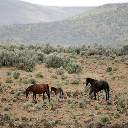

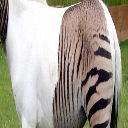

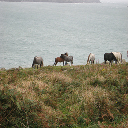

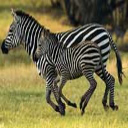

In [0]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self._encoder1 = self.encoder(3, 64, 4)
        self._encoder2 = self.encoder(64, 128, 4)
        self._encoder3 = self.encoder(128, 256, 4)

        # Residual net
        self._res1 = self.residual(256, 256, 3)
        self._res2 = self.residual(256, 256, 3)
        self._res3 = self.residual(256, 256, 3)
        
        # Decoder
        self._decoder1 = self.decoder(256, 128, 4)
        self._decoder2 = self.decoder(128, 64, 4)
        self._decoder3 = self.decoder2(64, 3, 4)

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), 
            nn.LeakyReLU(0.2)
        )
        return x

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), 
            nn.LeakyReLU(0.2),
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), 
            nn.LeakyReLU(0.2)
        )
        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), 
            nn.ReLU() 
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh (image values between -1 and 1)
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            #nn.Dropout2d(), 
            nn.Tanh()
        )
        return x   

    def forward(self, x):
        # Encode
        #m0 = x
        x = self._encoder1(x)
        #m1 = x
        x = self._encoder2(x)
        #m2 = x
        x = self._encoder3(x)
        #m3 = x

        # Resnet (the copy of the input take place here)
        a = self._res1(x)
        b = x + a
        c = self._res2(b)
        d = b + a 
        e = self._res3(d)
        x = d+ e
    
        # Decode + skipnet

        #x = x + m3
        x = self._decoder1(x)
        #x = x + m2
        x = self._decoder2(x)
        #x = x + m1
        x = self._decoder3(x)
        #x= x + m0

        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(int(512*image_size*image_size/(8*8)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        output = self._fc(x.view(-1, int(512*image_size*image_size/(8*8))))

        return output

## Model
Now lets create the core of our task, the model.

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizers(self):
        # generators optimizers
        self._opt_genA2B = torch.optim.Adam(self._generatorA2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_genB2A = torch.optim.Adam(self._generatorB2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminators optimizers
        self._opt_discrA = torch.optim.Adam(self._discriminatorA.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_discrB = torch.optim.Adam(self._discriminatorB.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss()# To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()# L1 for Cycle Consistency Loss
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        #
        loss_gA2B.backward(retain_graph=True)
        loss_gB2A.backward(retain_graph=True)
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        #
        # optimize discriminator A
        #
        for params in self._discriminatorA.parameters():
          params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_dA.item(), loss_dB.item(), loss_cyc.item()
             

## Train

In [0]:
num_epochs = 100
lambda_cyc = 5 # multiplier of the Cycle Consistency loss
model = Model(batch_size)

epoch: 1/5000, batch: 0/1067, GA2B_loss: 5.228802680969238, GB2A_loss: 5.229671478271484
                             DA_loss: 0.25137192010879517, DB_loss: 0.2504340410232544, CYC_loss: 0.9958994388580322


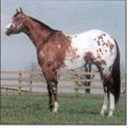

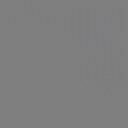

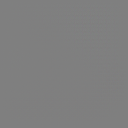

epoch: 1/5000, batch: 100/1067, GA2B_loss: 4.260357856750488, GB2A_loss: 4.218507289886475
                             DA_loss: 0.003165218746289611, DB_loss: 0.0017575430683791637, CYC_loss: 0.6698483228683472
epoch: 1/5000, batch: 200/1067, GA2B_loss: 3.6692304611206055, GB2A_loss: 3.1563122272491455
                             DA_loss: 0.09151875227689743, DB_loss: 0.003502951469272375, CYC_loss: 0.5657051205635071
epoch: 1/5000, batch: 300/1067, GA2B_loss: 4.280686855316162, GB2A_loss: 3.877323627471924
                             DA_loss: 0.37367698550224304, DB_loss: 0.08626510202884674, CYC_loss: 0.6568559408187866
epoch: 1/5000, batch: 400/1067, GA2B_loss: 3.578059434890747, GB2A_loss: 2.751169443130493
                             DA_loss: 0.31677180528640747, DB_loss: 0.0025454252026975155, CYC_loss: 0.5415236949920654
epoch: 1/5000, batch: 500/1067, GA2B_loss: 3.5451247692108154, GB2A_loss: 3.2101664543151855
                             DA_loss: 0.10584460943937302, DB_l

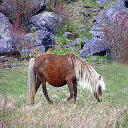

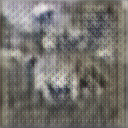

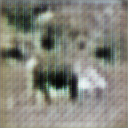

epoch: 2/5000, batch: 100/1067, GA2B_loss: 3.9092323780059814, GB2A_loss: 4.0005693435668945
                             DA_loss: 0.010654467158019543, DB_loss: 0.027198651805520058, CYC_loss: 0.6139245629310608
epoch: 2/5000, batch: 200/1067, GA2B_loss: 3.256664991378784, GB2A_loss: 3.1191110610961914
                             DA_loss: 0.005391809158027172, DB_loss: 0.057858992367982864, CYC_loss: 0.4631974399089813
epoch: 2/5000, batch: 300/1067, GA2B_loss: 3.647172689437866, GB2A_loss: 2.862874746322632
                             DA_loss: 0.17369061708450317, DB_loss: 0.0002965439925901592, CYC_loss: 0.5383639335632324
epoch: 2/5000, batch: 400/1067, GA2B_loss: 4.697696685791016, GB2A_loss: 4.584554195404053
                             DA_loss: 0.03050227090716362, DB_loss: 0.0022456711158156395, CYC_loss: 0.7648580074310303
epoch: 2/5000, batch: 500/1067, GA2B_loss: 2.651015520095825, GB2A_loss: 3.5509626865386963
                             DA_loss: 0.004542092327028513, D

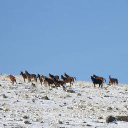

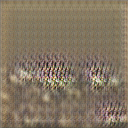

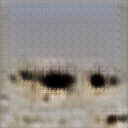

epoch: 3/5000, batch: 100/1067, GA2B_loss: 3.3689162731170654, GB2A_loss: 2.7002925872802734
                             DA_loss: 0.09856011718511581, DB_loss: 0.002155859023332596, CYC_loss: 0.4773036241531372
epoch: 3/5000, batch: 200/1067, GA2B_loss: 3.578468084335327, GB2A_loss: 2.7537498474121094
                             DA_loss: 0.23615668714046478, DB_loss: 0.07763601839542389, CYC_loss: 0.5311875343322754
epoch: 3/5000, batch: 300/1067, GA2B_loss: 2.9346930980682373, GB2A_loss: 3.2303431034088135
                             DA_loss: 0.03246046602725983, DB_loss: 0.3077338635921478, CYC_loss: 0.525460422039032
epoch: 3/5000, batch: 400/1067, GA2B_loss: 3.608961820602417, GB2A_loss: 4.008958339691162
                             DA_loss: 0.0635046735405922, DB_loss: 0.28143182396888733, CYC_loss: 0.7092298269271851
epoch: 3/5000, batch: 500/1067, GA2B_loss: 3.0039308071136475, GB2A_loss: 2.701080083847046
                             DA_loss: 0.12767578661441803, DB_loss: 0

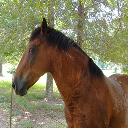

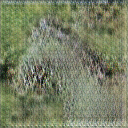

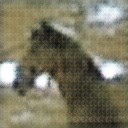

epoch: 4/5000, batch: 100/1067, GA2B_loss: 3.1087074279785156, GB2A_loss: 2.918741464614868
                             DA_loss: 0.04615703970193863, DB_loss: 0.10667820274829865, CYC_loss: 0.4773218631744385
epoch: 4/5000, batch: 200/1067, GA2B_loss: 2.90606951713562, GB2A_loss: 2.855342388153076
                             DA_loss: 0.0020702544134110212, DB_loss: 0.0022613010369241238, CYC_loss: 0.3852393627166748
epoch: 4/5000, batch: 300/1067, GA2B_loss: 3.6901254653930664, GB2A_loss: 3.431568145751953
                             DA_loss: 0.09149809181690216, DB_loss: 0.03726576268672943, CYC_loss: 0.5923605561256409
epoch: 4/5000, batch: 400/1067, GA2B_loss: 3.3874661922454834, GB2A_loss: 3.4006571769714355
                             DA_loss: 0.0672682598233223, DB_loss: 0.004973798990249634, CYC_loss: 0.49206531047821045
epoch: 4/5000, batch: 500/1067, GA2B_loss: 2.807535171508789, GB2A_loss: 2.938520908355713
                             DA_loss: 0.12351323664188385, DB_los

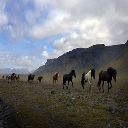

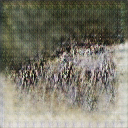

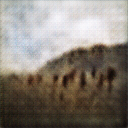

epoch: 5/5000, batch: 100/1067, GA2B_loss: 3.405379295349121, GB2A_loss: 3.3163177967071533
                             DA_loss: 0.006805333308875561, DB_loss: 0.01155652105808258, CYC_loss: 0.4973523020744324
epoch: 5/5000, batch: 200/1067, GA2B_loss: 4.308737754821777, GB2A_loss: 4.148224353790283
                             DA_loss: 0.07102297246456146, DB_loss: 0.00026242455351166427, CYC_loss: 0.6675794124603271
epoch: 5/5000, batch: 300/1067, GA2B_loss: 4.150757789611816, GB2A_loss: 4.413137912750244
                             DA_loss: 0.00020350809791125357, DB_loss: 0.04959600046277046, CYC_loss: 0.6899166107177734
epoch: 5/5000, batch: 400/1067, GA2B_loss: 5.004359245300293, GB2A_loss: 4.990659713745117
                             DA_loss: 0.001790798269212246, DB_loss: 0.12259947508573532, CYC_loss: 0.8198192715644836
epoch: 5/5000, batch: 500/1067, GA2B_loss: 3.513031005859375, GB2A_loss: 3.545011520385742
                             DA_loss: 0.0014016992645338178, DB_

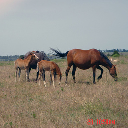

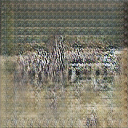

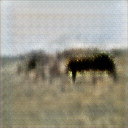

epoch: 6/5000, batch: 100/1067, GA2B_loss: 2.7809865474700928, GB2A_loss: 2.4838969707489014
                             DA_loss: 0.015456562861800194, DB_loss: 0.00022862506739329547, CYC_loss: 0.3602352440357208
epoch: 6/5000, batch: 200/1067, GA2B_loss: 2.421945810317993, GB2A_loss: 3.238029718399048
                             DA_loss: 0.009562937542796135, DB_loss: 0.2715625762939453, CYC_loss: 0.47038373351097107
epoch: 6/5000, batch: 300/1067, GA2B_loss: 2.4729323387145996, GB2A_loss: 3.0441973209381104
                             DA_loss: 0.004358481615781784, DB_loss: 0.10750652104616165, CYC_loss: 0.43630877137184143
epoch: 6/5000, batch: 400/1067, GA2B_loss: 3.124448299407959, GB2A_loss: 3.3474953174591064
                             DA_loss: 0.020755520090460777, DB_loss: 0.017293330281972885, CYC_loss: 0.4913591742515564
epoch: 6/5000, batch: 500/1067, GA2B_loss: 2.9951229095458984, GB2A_loss: 2.780880928039551
                             DA_loss: 0.06677518784999847,

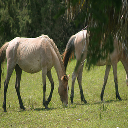

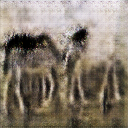

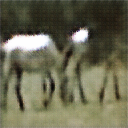

epoch: 7/5000, batch: 100/1067, GA2B_loss: 2.8991799354553223, GB2A_loss: 2.81624174118042
                             DA_loss: 0.020328618586063385, DB_loss: 0.0003075763816013932, CYC_loss: 0.3895725607872009
epoch: 7/5000, batch: 200/1067, GA2B_loss: 3.0377373695373535, GB2A_loss: 2.900292158126831
                             DA_loss: 0.29594266414642334, DB_loss: 0.0013364172773435712, CYC_loss: 0.4221865236759186
epoch: 7/5000, batch: 300/1067, GA2B_loss: 3.008580207824707, GB2A_loss: 2.2349085807800293
                             DA_loss: 0.2763541340827942, DB_loss: 0.007548788096755743, CYC_loss: 0.4300888180732727
epoch: 7/5000, batch: 400/1067, GA2B_loss: 3.042227268218994, GB2A_loss: 2.913778066635132
                             DA_loss: 0.027517961338162422, DB_loss: 0.019645290449261665, CYC_loss: 0.46556153893470764
epoch: 7/5000, batch: 500/1067, GA2B_loss: 3.1032190322875977, GB2A_loss: 2.316117525100708
                             DA_loss: 0.14879044890403748, DB_

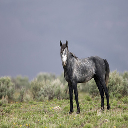

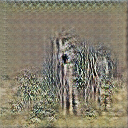

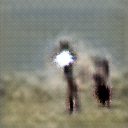

epoch: 8/5000, batch: 100/1067, GA2B_loss: 3.707118511199951, GB2A_loss: 3.7378640174865723
                             DA_loss: 0.014106446877121925, DB_loss: 0.021457146853208542, CYC_loss: 0.6090705394744873
epoch: 8/5000, batch: 200/1067, GA2B_loss: 2.6459436416625977, GB2A_loss: 2.648409128189087
                             DA_loss: 0.0035882769152522087, DB_loss: 0.05268874391913414, CYC_loss: 0.3404783606529236
epoch: 8/5000, batch: 300/1067, GA2B_loss: 3.3612492084503174, GB2A_loss: 3.364924430847168
                             DA_loss: 0.0009268383146263659, DB_loss: 0.17223301529884338, CYC_loss: 0.4882572293281555
epoch: 8/5000, batch: 400/1067, GA2B_loss: 2.8495004177093506, GB2A_loss: 3.030467987060547
                             DA_loss: 0.20032939314842224, DB_loss: 0.006960837636142969, CYC_loss: 0.4141896665096283
epoch: 8/5000, batch: 500/1067, GA2B_loss: 3.076539993286133, GB2A_loss: 2.9736080169677734
                             DA_loss: 0.008074382320046425, D

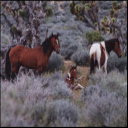

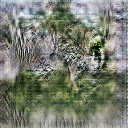

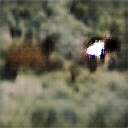

epoch: 9/5000, batch: 100/1067, GA2B_loss: 3.1057422161102295, GB2A_loss: 2.796015739440918
                             DA_loss: 0.015248868614435196, DB_loss: 0.410329669713974, CYC_loss: 0.42237645387649536
epoch: 9/5000, batch: 200/1067, GA2B_loss: 3.058682441711426, GB2A_loss: 3.161742687225342
                             DA_loss: 0.0037092312704771757, DB_loss: 0.010431882925331593, CYC_loss: 0.46530866622924805
epoch: 9/5000, batch: 300/1067, GA2B_loss: 3.257591724395752, GB2A_loss: 2.6294047832489014
                             DA_loss: 0.30296289920806885, DB_loss: 0.01565863937139511, CYC_loss: 0.5160415172576904
epoch: 9/5000, batch: 400/1067, GA2B_loss: 3.4860646724700928, GB2A_loss: 3.376546859741211
                             DA_loss: 0.0022668757010251284, DB_loss: 7.837527664378285e-05, CYC_loss: 0.501335084438324
epoch: 9/5000, batch: 500/1067, GA2B_loss: 3.2242112159729004, GB2A_loss: 2.8357667922973633
                             DA_loss: 0.03532391041517258, DB

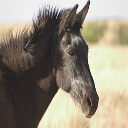

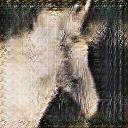

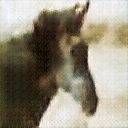

epoch: 10/5000, batch: 100/1067, GA2B_loss: 3.344346046447754, GB2A_loss: 2.9807753562927246
                             DA_loss: 0.02519472874701023, DB_loss: 0.30797192454338074, CYC_loss: 0.4750785827636719
epoch: 10/5000, batch: 200/1067, GA2B_loss: 3.504812717437744, GB2A_loss: 3.1602418422698975
                             DA_loss: 0.0320245698094368, DB_loss: 0.001551144989207387, CYC_loss: 0.5203847885131836
epoch: 10/5000, batch: 300/1067, GA2B_loss: 3.323723793029785, GB2A_loss: 3.2891788482666016
                             DA_loss: 0.10302404314279556, DB_loss: 0.0851234719157219, CYC_loss: 0.5957393646240234
epoch: 10/5000, batch: 400/1067, GA2B_loss: 3.0303423404693604, GB2A_loss: 2.7333719730377197
                             DA_loss: 0.0337321013212204, DB_loss: 0.020401613786816597, CYC_loss: 0.40790504217147827
epoch: 10/5000, batch: 500/1067, GA2B_loss: 3.8080666065216064, GB2A_loss: 3.5627224445343018
                             DA_loss: 0.03397391736507416, DB

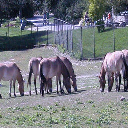

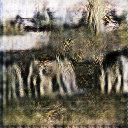

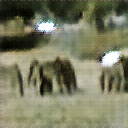

epoch: 11/5000, batch: 100/1067, GA2B_loss: 3.2034411430358887, GB2A_loss: 2.9637184143066406
                             DA_loss: 0.009127183817327023, DB_loss: 0.0004546316049527377, CYC_loss: 0.4431361258029938
epoch: 11/5000, batch: 200/1067, GA2B_loss: 2.5975942611694336, GB2A_loss: 2.128514289855957
                             DA_loss: 0.048551421612501144, DB_loss: 0.0004195478104520589, CYC_loss: 0.33092227578163147
epoch: 11/5000, batch: 300/1067, GA2B_loss: 2.23028826713562, GB2A_loss: 3.1571335792541504
                             DA_loss: 0.0003751473850570619, DB_loss: 0.3538545072078705, CYC_loss: 0.4410092532634735
epoch: 11/5000, batch: 400/1067, GA2B_loss: 3.133711576461792, GB2A_loss: 2.8765735626220703
                             DA_loss: 0.06196427345275879, DB_loss: 0.0018213812727481127, CYC_loss: 0.44244539737701416
epoch: 11/5000, batch: 500/1067, GA2B_loss: 3.7863528728485107, GB2A_loss: 3.883878469467163
                             DA_loss: 0.018559116870

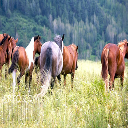

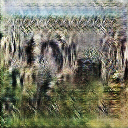

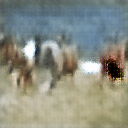

epoch: 12/5000, batch: 100/1067, GA2B_loss: 3.0968687534332275, GB2A_loss: 3.0845589637756348
                             DA_loss: 0.005725426133722067, DB_loss: 0.0005690162070095539, CYC_loss: 0.4199301302433014
epoch: 12/5000, batch: 200/1067, GA2B_loss: 3.658761501312256, GB2A_loss: 3.086230754852295
                             DA_loss: 0.09678299725055695, DB_loss: 0.0012285225093364716, CYC_loss: 0.5510883331298828
epoch: 12/5000, batch: 300/1067, GA2B_loss: 3.0325324535369873, GB2A_loss: 3.023998975753784
                             DA_loss: 0.003329033497720957, DB_loss: 0.0006985913496464491, CYC_loss: 0.42050644755363464
epoch: 12/5000, batch: 400/1067, GA2B_loss: 3.4990878105163574, GB2A_loss: 3.233595848083496
                             DA_loss: 0.06784989684820175, DB_loss: 0.017088212072849274, CYC_loss: 0.5669286251068115
epoch: 12/5000, batch: 500/1067, GA2B_loss: 2.753619909286499, GB2A_loss: 1.821027159690857
                             DA_loss: 0.44937631487846

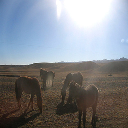

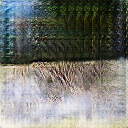

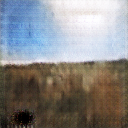

epoch: 13/5000, batch: 100/1067, GA2B_loss: 2.925259828567505, GB2A_loss: 3.053504228591919
                             DA_loss: 0.30157265067100525, DB_loss: 0.004262929316610098, CYC_loss: 0.4200052320957184
epoch: 13/5000, batch: 200/1067, GA2B_loss: 2.6098155975341797, GB2A_loss: 2.4676730632781982
                             DA_loss: 0.01152825728058815, DB_loss: 0.0090152807533741, CYC_loss: 0.3437066078186035
epoch: 13/5000, batch: 300/1067, GA2B_loss: 2.275930643081665, GB2A_loss: 2.378176689147949
                             DA_loss: 0.0008380325743928552, DB_loss: 0.012843582779169083, CYC_loss: 0.2913494110107422
epoch: 13/5000, batch: 400/1067, GA2B_loss: 2.6941518783569336, GB2A_loss: 2.674858808517456
                             DA_loss: 0.0001475363678764552, DB_loss: 5.577877345785964e-06, CYC_loss: 0.34016066789627075
epoch: 13/5000, batch: 500/1067, GA2B_loss: 3.0269947052001953, GB2A_loss: 2.9882876873016357
                             DA_loss: 0.020029379054903

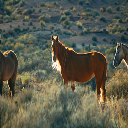

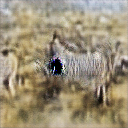

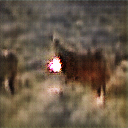

epoch: 14/5000, batch: 100/1067, GA2B_loss: 2.8990542888641357, GB2A_loss: 2.893449544906616
                             DA_loss: 0.3868892788887024, DB_loss: 0.0004719359567388892, CYC_loss: 0.3914104104042053
epoch: 14/5000, batch: 200/1067, GA2B_loss: 2.7313358783721924, GB2A_loss: 2.722269296646118
                             DA_loss: 0.003099271561950445, DB_loss: 0.0001753328542690724, CYC_loss: 0.3536074459552765
epoch: 14/5000, batch: 300/1067, GA2B_loss: 4.0665998458862305, GB2A_loss: 4.133988380432129
                             DA_loss: 0.00014421746891457587, DB_loss: 0.0022760783322155476, CYC_loss: 0.633532702922821
epoch: 14/5000, batch: 400/1067, GA2B_loss: 2.9408631324768066, GB2A_loss: 2.2109529972076416
                             DA_loss: 0.5258640050888062, DB_loss: 0.010441082529723644, CYC_loss: 0.4417698383331299
epoch: 14/5000, batch: 500/1067, GA2B_loss: 3.652029037475586, GB2A_loss: 3.6221015453338623
                             DA_loss: 0.00512380339205

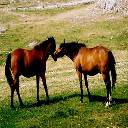

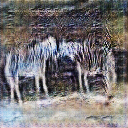

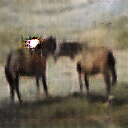

epoch: 15/5000, batch: 100/1067, GA2B_loss: 3.3212599754333496, GB2A_loss: 3.441504955291748
                             DA_loss: 0.16257905960083008, DB_loss: 0.002979311626404524, CYC_loss: 0.48855555057525635
epoch: 15/5000, batch: 200/1067, GA2B_loss: 2.390387535095215, GB2A_loss: 2.934985399246216
                             DA_loss: 0.00012398917169775814, DB_loss: 0.06129588186740875, CYC_loss: 0.3932464122772217
epoch: 15/5000, batch: 300/1067, GA2B_loss: 2.828317403793335, GB2A_loss: 2.731602191925049
                             DA_loss: 0.0019476186716929078, DB_loss: 6.81522287777625e-05, CYC_loss: 0.37030619382858276
epoch: 15/5000, batch: 400/1067, GA2B_loss: 2.2793760299682617, GB2A_loss: 2.3422627449035645
                             DA_loss: 0.047839973121881485, DB_loss: 0.0007193515193648636, CYC_loss: 0.2704879939556122
epoch: 15/5000, batch: 500/1067, GA2B_loss: 3.0259616374969482, GB2A_loss: 2.947477340698242
                             DA_loss: 0.000859187333

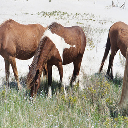

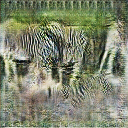

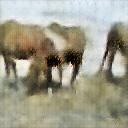

epoch: 16/5000, batch: 100/1067, GA2B_loss: 3.090125799179077, GB2A_loss: 3.2375917434692383
                             DA_loss: 0.26145732402801514, DB_loss: 0.003482207888737321, CYC_loss: 0.4500078856945038
epoch: 16/5000, batch: 200/1067, GA2B_loss: 3.122692108154297, GB2A_loss: 2.5623984336853027
                             DA_loss: 0.1096486821770668, DB_loss: 0.003380649723112583, CYC_loss: 0.4559340178966522
epoch: 16/5000, batch: 300/1067, GA2B_loss: 2.7581467628479004, GB2A_loss: 2.3711719512939453
                             DA_loss: 0.025519978255033493, DB_loss: 0.018447820097208023, CYC_loss: 0.3543921709060669
epoch: 16/5000, batch: 400/1067, GA2B_loss: 3.118645668029785, GB2A_loss: 3.1078007221221924
                             DA_loss: 3.044282493647188e-05, DB_loss: 3.306058715679683e-05, CYC_loss: 0.4246690273284912
epoch: 16/5000, batch: 500/1067, GA2B_loss: 2.4535818099975586, GB2A_loss: 2.8781893253326416
                             DA_loss: 0.05310018360614

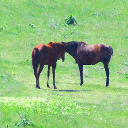

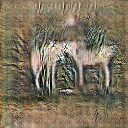

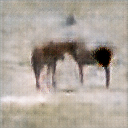

epoch: 17/5000, batch: 100/1067, GA2B_loss: 2.892951250076294, GB2A_loss: 2.238783836364746
                             DA_loss: 0.09663943201303482, DB_loss: 0.01587485708296299, CYC_loss: 0.38454705476760864
epoch: 17/5000, batch: 200/1067, GA2B_loss: 2.8552141189575195, GB2A_loss: 3.2945518493652344
                             DA_loss: 5.35472427145578e-05, DB_loss: 0.03514280170202255, CYC_loss: 0.46302300691604614
epoch: 17/5000, batch: 300/1067, GA2B_loss: 2.9483306407928467, GB2A_loss: 2.9180119037628174
                             DA_loss: 0.0006091090035624802, DB_loss: 0.05041760206222534, CYC_loss: 0.39491763710975647
epoch: 17/5000, batch: 400/1067, GA2B_loss: 3.1865925788879395, GB2A_loss: 3.6341702938079834
                             DA_loss: 0.1821599006652832, DB_loss: 0.0334196500480175, CYC_loss: 0.5271853804588318
epoch: 17/5000, batch: 500/1067, GA2B_loss: 2.9977855682373047, GB2A_loss: 3.0720295906066895
                             DA_loss: 0.0003235339827369

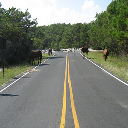

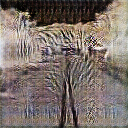

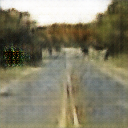

epoch: 18/5000, batch: 100/1067, GA2B_loss: 2.583926200866699, GB2A_loss: 2.6988561153411865
                             DA_loss: 0.00011715173604898155, DB_loss: 0.04796816408634186, CYC_loss: 0.3402078151702881
epoch: 18/5000, batch: 200/1067, GA2B_loss: 2.900435447692871, GB2A_loss: 2.647355556488037
                             DA_loss: 0.010981888510286808, DB_loss: 0.14253483712673187, CYC_loss: 0.38105508685112
epoch: 18/5000, batch: 300/1067, GA2B_loss: 3.329606771469116, GB2A_loss: 3.250403642654419
                             DA_loss: 0.0012476572301238775, DB_loss: 4.423053724167403e-06, CYC_loss: 0.4670141935348511
epoch: 18/5000, batch: 400/1067, GA2B_loss: 2.491826295852661, GB2A_loss: 2.886200428009033
                             DA_loss: 0.28569841384887695, DB_loss: 0.025779852643609047, CYC_loss: 0.37821727991104126
epoch: 18/5000, batch: 500/1067, GA2B_loss: 2.462812662124634, GB2A_loss: 2.184016227722168
                             DA_loss: 0.025846250355243683,

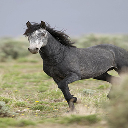

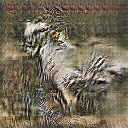

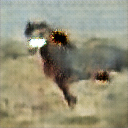

epoch: 19/5000, batch: 100/1067, GA2B_loss: 3.1655828952789307, GB2A_loss: 3.031704902648926
                             DA_loss: 0.0026453302707523108, DB_loss: 8.048703602980822e-05, CYC_loss: 0.4343529939651489
epoch: 19/5000, batch: 200/1067, GA2B_loss: 2.7065701484680176, GB2A_loss: 2.9067635536193848
                             DA_loss: 0.0002004786947509274, DB_loss: 0.008191529661417007, CYC_loss: 0.389234721660614
epoch: 19/5000, batch: 300/1067, GA2B_loss: 3.0284759998321533, GB2A_loss: 2.360643148422241
                             DA_loss: 0.11542624235153198, DB_loss: 0.0004572033358272165, CYC_loss: 0.41760724782943726
epoch: 19/5000, batch: 400/1067, GA2B_loss: 3.6406145095825195, GB2A_loss: 3.444316864013672
                             DA_loss: 0.03587064519524574, DB_loss: 0.010405203327536583, CYC_loss: 0.5816529393196106
epoch: 19/5000, batch: 500/1067, GA2B_loss: 2.884289026260376, GB2A_loss: 2.8352925777435303
                             DA_loss: 0.167002305388

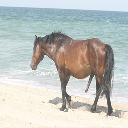

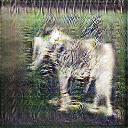

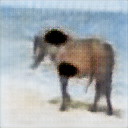

epoch: 20/5000, batch: 100/1067, GA2B_loss: 3.9035966396331787, GB2A_loss: 3.849071502685547
                             DA_loss: 0.0007654521614313126, DB_loss: 7.316150004044175e-05, CYC_loss: 0.5851588249206543
epoch: 20/5000, batch: 200/1067, GA2B_loss: 3.103318691253662, GB2A_loss: 3.14072847366333
                             DA_loss: 0.00011215668200748041, DB_loss: 0.0011658875737339258, CYC_loss: 0.4339922070503235
epoch: 20/5000, batch: 300/1067, GA2B_loss: 2.790759801864624, GB2A_loss: 2.8355371952056885
                             DA_loss: 0.08950045704841614, DB_loss: 0.0015055076219141483, CYC_loss: 0.3674911856651306
epoch: 20/5000, batch: 400/1067, GA2B_loss: 2.976057529449463, GB2A_loss: 3.058302640914917
                             DA_loss: 0.026235632598400116, DB_loss: 0.001069766003638506, CYC_loss: 0.41328561305999756
epoch: 20/5000, batch: 500/1067, GA2B_loss: 2.419889211654663, GB2A_loss: 2.605837821960449
                             DA_loss: 3.5027362173423

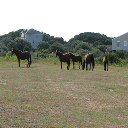

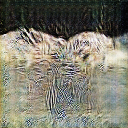

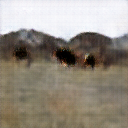

epoch: 21/5000, batch: 100/1067, GA2B_loss: 2.6446003913879395, GB2A_loss: 2.6805639266967773
                             DA_loss: 0.031668514013290405, DB_loss: 0.009041172452270985, CYC_loss: 0.36136430501937866
epoch: 21/5000, batch: 200/1067, GA2B_loss: 3.0143117904663086, GB2A_loss: 2.5753250122070312
                             DA_loss: 0.032343391329050064, DB_loss: 0.000253575126407668, CYC_loss: 0.4037996828556061
epoch: 21/5000, batch: 300/1067, GA2B_loss: 1.9369242191314697, GB2A_loss: 2.5895299911499023
                             DA_loss: 0.0019192231120541692, DB_loss: 0.12747864425182343, CYC_loss: 0.3383665084838867
epoch: 21/5000, batch: 400/1067, GA2B_loss: 2.285290479660034, GB2A_loss: 2.909600257873535
                             DA_loss: 0.009977789595723152, DB_loss: 0.2224768102169037, CYC_loss: 0.43371713161468506
epoch: 21/5000, batch: 500/1067, GA2B_loss: 2.703463554382324, GB2A_loss: 2.6889305114746094
                             DA_loss: 0.0159116927534

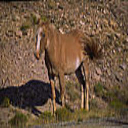

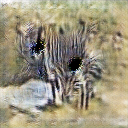

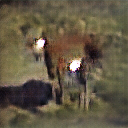

epoch: 22/5000, batch: 100/1067, GA2B_loss: 2.333548069000244, GB2A_loss: 3.0312113761901855
                             DA_loss: 0.004118363372981548, DB_loss: 0.2040017694234848, CYC_loss: 0.44059985876083374
epoch: 22/5000, batch: 200/1067, GA2B_loss: 3.112589120864868, GB2A_loss: 2.872248649597168
                             DA_loss: 0.009079165756702423, DB_loss: 0.003358312649652362, CYC_loss: 0.4247192144393921
epoch: 22/5000, batch: 300/1067, GA2B_loss: 3.6137161254882812, GB2A_loss: 3.422957420349121
                             DA_loss: 0.00731529388576746, DB_loss: 0.0008522744756191969, CYC_loss: 0.5300477743148804
epoch: 22/5000, batch: 400/1067, GA2B_loss: 2.9131178855895996, GB2A_loss: 2.9036755561828613
                             DA_loss: 0.00012963575136382133, DB_loss: 6.369569018715993e-05, CYC_loss: 0.387112557888031
epoch: 22/5000, batch: 500/1067, GA2B_loss: 2.182079315185547, GB2A_loss: 2.238783836364746
                             DA_loss: 0.117888346314430

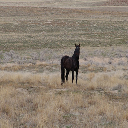

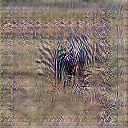

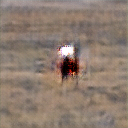

epoch: 23/5000, batch: 100/1067, GA2B_loss: 3.130136489868164, GB2A_loss: 3.0476627349853516
                             DA_loss: 0.007422632537782192, DB_loss: 0.0003618064511101693, CYC_loss: 0.4365767240524292
epoch: 23/5000, batch: 200/1067, GA2B_loss: 3.6595823764801025, GB2A_loss: 3.2483625411987305
                             DA_loss: 0.02735627070069313, DB_loss: 0.3574292063713074, CYC_loss: 0.5322924852371216
epoch: 23/5000, batch: 300/1067, GA2B_loss: 2.4478163719177246, GB2A_loss: 2.4495184421539307
                             DA_loss: 0.028559833765029907, DB_loss: 0.0009350087493658066, CYC_loss: 0.2902469336986542
epoch: 23/5000, batch: 400/1067, GA2B_loss: 2.550621747970581, GB2A_loss: 2.457070827484131
                             DA_loss: 0.002549857832491398, DB_loss: 0.0011601197766140103, CYC_loss: 0.31074821949005127
epoch: 23/5000, batch: 500/1067, GA2B_loss: 2.126776933670044, GB2A_loss: 2.619084119796753
                             DA_loss: 0.00063322175992

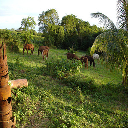

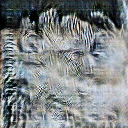

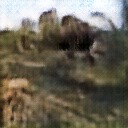

epoch: 24/5000, batch: 100/1067, GA2B_loss: 2.8363707065582275, GB2A_loss: 2.871542453765869
                             DA_loss: 0.0007788793882355094, DB_loss: 0.0003322919365018606, CYC_loss: 0.37745246291160583
epoch: 24/5000, batch: 200/1067, GA2B_loss: 2.608186721801758, GB2A_loss: 2.6131646633148193
                             DA_loss: 0.12409364432096481, DB_loss: 0.010193883441388607, CYC_loss: 0.3746740520000458
epoch: 24/5000, batch: 300/1067, GA2B_loss: 2.1024301052093506, GB2A_loss: 2.631826877593994
                             DA_loss: 0.001542343758046627, DB_loss: 0.06515336781740189, CYC_loss: 0.33740365505218506
epoch: 24/5000, batch: 400/1067, GA2B_loss: 2.971930503845215, GB2A_loss: 2.4498238563537598
                             DA_loss: 0.07036061584949493, DB_loss: 0.003062507603317499, CYC_loss: 0.39934825897216797
epoch: 24/5000, batch: 500/1067, GA2B_loss: 2.75429105758667, GB2A_loss: 2.8439221382141113
                             DA_loss: 0.00096508435672

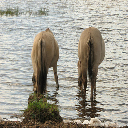

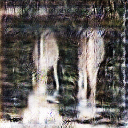

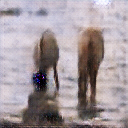

epoch: 25/5000, batch: 100/1067, GA2B_loss: 2.653240203857422, GB2A_loss: 2.061964750289917
                             DA_loss: 0.06912248581647873, DB_loss: 0.00017289374954998493, CYC_loss: 0.3334600031375885
epoch: 25/5000, batch: 200/1067, GA2B_loss: 2.9562621116638184, GB2A_loss: 2.9511566162109375
                             DA_loss: 0.0009419651469215751, DB_loss: 0.014483541250228882, CYC_loss: 0.3916386663913727
epoch: 25/5000, batch: 300/1067, GA2B_loss: 2.902320146560669, GB2A_loss: 2.405939817428589
                             DA_loss: 0.04488595202565193, DB_loss: 1.1674648703774437e-05, CYC_loss: 0.38238853216171265
epoch: 25/5000, batch: 400/1067, GA2B_loss: 3.257657051086426, GB2A_loss: 3.4285049438476562
                             DA_loss: 0.0012623521033674479, DB_loss: 0.004227877594530582, CYC_loss: 0.48661139607429504
epoch: 25/5000, batch: 500/1067, GA2B_loss: 3.7569661140441895, GB2A_loss: 3.7615013122558594
                             DA_loss: 0.000122905

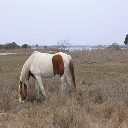

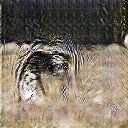

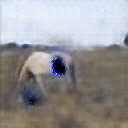

epoch: 26/5000, batch: 100/1067, GA2B_loss: 2.366178035736084, GB2A_loss: 2.6826043128967285
                             DA_loss: 0.02099592238664627, DB_loss: 0.0959240198135376, CYC_loss: 0.4100678265094757
epoch: 26/5000, batch: 200/1067, GA2B_loss: 3.169166326522827, GB2A_loss: 3.1663451194763184
                             DA_loss: 0.00021342547552194446, DB_loss: 3.8083928188825666e-07, CYC_loss: 0.43409478664398193
epoch: 26/5000, batch: 300/1067, GA2B_loss: 2.6873979568481445, GB2A_loss: 2.6960792541503906
                             DA_loss: 9.173175385512877e-06, DB_loss: 0.1270245462656021, CYC_loss: 0.3409123718738556
epoch: 26/5000, batch: 400/1067, GA2B_loss: 2.5266101360321045, GB2A_loss: 2.4831416606903076
                             DA_loss: 0.062404658645391464, DB_loss: 0.00039833251503296196, CYC_loss: 0.3164518475532532
epoch: 26/5000, batch: 500/1067, GA2B_loss: 2.920750379562378, GB2A_loss: 2.9018092155456543
                             DA_loss: 0.0001640854

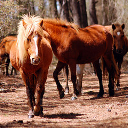

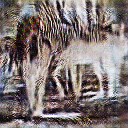

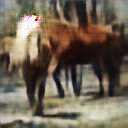

epoch: 27/5000, batch: 100/1067, GA2B_loss: 2.554633617401123, GB2A_loss: 2.5401387214660645
                             DA_loss: 0.0896211639046669, DB_loss: 0.0058599961921572685, CYC_loss: 0.3138885498046875
epoch: 27/5000, batch: 200/1067, GA2B_loss: 2.6205921173095703, GB2A_loss: 2.919266700744629
                             DA_loss: 0.007527858484536409, DB_loss: 0.049139805138111115, CYC_loss: 0.4298325777053833
epoch: 27/5000, batch: 300/1067, GA2B_loss: 3.0552806854248047, GB2A_loss: 3.035004138946533
                             DA_loss: 6.441870209528133e-05, DB_loss: 0.012209225445985794, CYC_loss: 0.4114946126937866
epoch: 27/5000, batch: 400/1067, GA2B_loss: 2.779266119003296, GB2A_loss: 2.7803852558135986
                             DA_loss: 2.0629065033972438e-07, DB_loss: 0.05578216165304184, CYC_loss: 0.356284499168396
epoch: 27/5000, batch: 500/1067, GA2B_loss: 2.559739112854004, GB2A_loss: 2.664672374725342
                             DA_loss: 5.215343662712257e

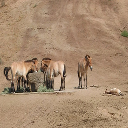

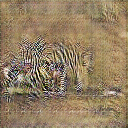

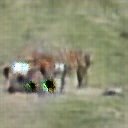

epoch: 28/5000, batch: 100/1067, GA2B_loss: 2.609950065612793, GB2A_loss: 2.6748056411743164
                             DA_loss: 2.6656594855012372e-05, DB_loss: 0.0005846364656463265, CYC_loss: 0.3354225754737854
epoch: 28/5000, batch: 200/1067, GA2B_loss: 1.571810007095337, GB2A_loss: 1.530153512954712
                             DA_loss: 0.05175197497010231, DB_loss: 0.0430273674428463, CYC_loss: 0.21387942135334015
epoch: 28/5000, batch: 300/1067, GA2B_loss: 2.9112935066223145, GB2A_loss: 2.6807987689971924
                             DA_loss: 0.020000888034701347, DB_loss: 0.0022448692470788956, CYC_loss: 0.40816107392311096
epoch: 28/5000, batch: 400/1067, GA2B_loss: 2.7033402919769287, GB2A_loss: 2.6253256797790527
                             DA_loss: 0.0017230566591024399, DB_loss: 0.0003101855400018394, CYC_loss: 0.34785735607147217
epoch: 28/5000, batch: 500/1067, GA2B_loss: 3.184600591659546, GB2A_loss: 3.1831412315368652
                             DA_loss: 2.59014223

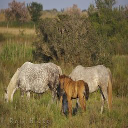

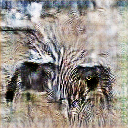

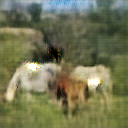

epoch: 29/5000, batch: 100/1067, GA2B_loss: 2.879577875137329, GB2A_loss: 2.918574333190918
                             DA_loss: 0.0012759920209646225, DB_loss: 0.001251822803169489, CYC_loss: 0.38507279753685
epoch: 29/5000, batch: 200/1067, GA2B_loss: 2.7864742279052734, GB2A_loss: 2.9506208896636963
                             DA_loss: 8.548751065973192e-05, DB_loss: 0.005006047431379557, CYC_loss: 0.39531654119491577
epoch: 29/5000, batch: 300/1067, GA2B_loss: 3.16342830657959, GB2A_loss: 3.1611640453338623
                             DA_loss: 0.0006250124424695969, DB_loss: 0.009777923114597797, CYC_loss: 0.43269920349121094
epoch: 29/5000, batch: 400/1067, GA2B_loss: 1.7436562776565552, GB2A_loss: 2.3421502113342285
                             DA_loss: 6.020426008035429e-05, DB_loss: 0.07365886867046356, CYC_loss: 0.27279311418533325
epoch: 29/5000, batch: 500/1067, GA2B_loss: 2.851546287536621, GB2A_loss: 2.866882562637329
                             DA_loss: 0.000126680271

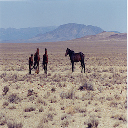

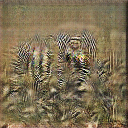

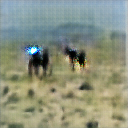

epoch: 30/5000, batch: 100/1067, GA2B_loss: 2.872011661529541, GB2A_loss: 2.8961238861083984
                             DA_loss: 2.0375549866002984e-05, DB_loss: 0.00017293987912125885, CYC_loss: 0.3817700743675232
epoch: 30/5000, batch: 200/1067, GA2B_loss: 2.9009931087493896, GB2A_loss: 2.8970327377319336
                             DA_loss: 1.2580043403431773e-05, DB_loss: 2.239145942439791e-06, CYC_loss: 0.3810063600540161
epoch: 30/5000, batch: 300/1067, GA2B_loss: 2.838885545730591, GB2A_loss: 2.848207473754883
                             DA_loss: 2.2854694179841317e-05, DB_loss: 1.1603178791119717e-05, CYC_loss: 0.3696978688240051
epoch: 30/5000, batch: 400/1067, GA2B_loss: 3.2333805561065674, GB2A_loss: 3.234671115875244
                             DA_loss: 0.03509299457073212, DB_loss: 0.014409610070288181, CYC_loss: 0.44762352108955383
epoch: 30/5000, batch: 500/1067, GA2B_loss: 2.5256433486938477, GB2A_loss: 2.413292407989502
                             DA_loss: 0.0026

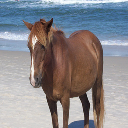

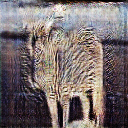

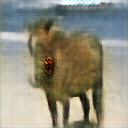

epoch: 31/5000, batch: 100/1067, GA2B_loss: 2.9596147537231445, GB2A_loss: 3.182751417160034
                             DA_loss: 0.16290783882141113, DB_loss: 0.007486650720238686, CYC_loss: 0.4378744065761566
epoch: 31/5000, batch: 200/1067, GA2B_loss: 2.5036346912384033, GB2A_loss: 2.3415234088897705
                             DA_loss: 0.0036166799254715443, DB_loss: 7.094258336337589e-08, CYC_loss: 0.30087757110595703
epoch: 31/5000, batch: 300/1067, GA2B_loss: 3.263777017593384, GB2A_loss: 3.331293821334839
                             DA_loss: 1.2854702617914882e-06, DB_loss: 0.0006797215901315212, CYC_loss: 0.46689921617507935
epoch: 31/5000, batch: 400/1067, GA2B_loss: 2.751781463623047, GB2A_loss: 2.6958022117614746
                             DA_loss: 0.0005730747943744063, DB_loss: 1.5396046364912763e-05, CYC_loss: 0.3505808115005493
epoch: 31/5000, batch: 500/1067, GA2B_loss: 2.9343204498291016, GB2A_loss: 2.777764081954956
                             DA_loss: 0.014953

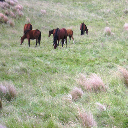

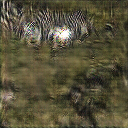

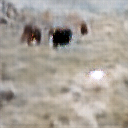

epoch: 32/5000, batch: 100/1067, GA2B_loss: 2.2638680934906006, GB2A_loss: 2.5220947265625
                             DA_loss: 0.00017651187954470515, DB_loss: 0.011945520527660847, CYC_loss: 0.30982229113578796
epoch: 32/5000, batch: 200/1067, GA2B_loss: 2.940962076187134, GB2A_loss: 2.9211878776550293
                             DA_loss: 5.31014557054732e-05, DB_loss: 7.950122267175175e-07, CYC_loss: 0.388269305229187
epoch: 32/5000, batch: 300/1067, GA2B_loss: 2.420790910720825, GB2A_loss: 2.46237850189209
                             DA_loss: 3.7727302697021514e-05, DB_loss: 0.00045225804205983877, CYC_loss: 0.29572126269340515
epoch: 32/5000, batch: 400/1067, GA2B_loss: 2.601095199584961, GB2A_loss: 2.6120786666870117
                             DA_loss: 0.00334180542267859, DB_loss: 0.0002924878499470651, CYC_loss: 0.32976412773132324
epoch: 32/5000, batch: 500/1067, GA2B_loss: 2.9514334201812744, GB2A_loss: 2.9362082481384277
                             DA_loss: 0.006086686

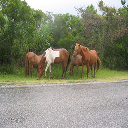

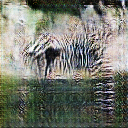

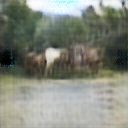

epoch: 33/5000, batch: 100/1067, GA2B_loss: 3.124227285385132, GB2A_loss: 3.1340317726135254
                             DA_loss: 3.751470285351388e-05, DB_loss: 3.121474583167583e-05, CYC_loss: 0.4278600215911865
epoch: 33/5000, batch: 200/1067, GA2B_loss: 2.56857967376709, GB2A_loss: 2.6524157524108887
                             DA_loss: 6.864198439870961e-06, DB_loss: 0.0013511951547116041, CYC_loss: 0.3319617509841919
epoch: 33/5000, batch: 300/1067, GA2B_loss: 2.6085429191589355, GB2A_loss: 2.7425997257232666
                             DA_loss: 0.00454400759190321, DB_loss: 0.037554334849119186, CYC_loss: 0.3668384253978729
epoch: 33/5000, batch: 400/1067, GA2B_loss: 2.276993989944458, GB2A_loss: 2.2777087688446045
                             DA_loss: 2.2720330889569595e-05, DB_loss: 1.0723344985308358e-06, CYC_loss: 0.2558189630508423
epoch: 33/5000, batch: 500/1067, GA2B_loss: 2.917717456817627, GB2A_loss: 2.912410259246826
                             DA_loss: 5.061395313

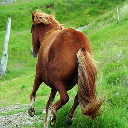

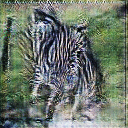

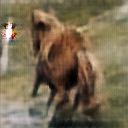

epoch: 34/5000, batch: 100/1067, GA2B_loss: 2.568222999572754, GB2A_loss: 2.763260841369629
                             DA_loss: 0.0004287213378120214, DB_loss: 0.009187642484903336, CYC_loss: 0.3641917407512665
epoch: 34/5000, batch: 200/1067, GA2B_loss: 2.9992313385009766, GB2A_loss: 2.5399746894836426
                             DA_loss: 0.041399337351322174, DB_loss: 1.7558504623593763e-05, CYC_loss: 0.4016304016113281
epoch: 34/5000, batch: 300/1067, GA2B_loss: 2.765842914581299, GB2A_loss: 2.570112705230713
                             DA_loss: 0.005376947112381458, DB_loss: 0.22251246869564056, CYC_loss: 0.3533521592617035
epoch: 34/5000, batch: 400/1067, GA2B_loss: 2.267547607421875, GB2A_loss: 1.5630292892456055
                             DA_loss: 0.10418717563152313, DB_loss: 0.037609219551086426, CYC_loss: 0.2535221576690674
epoch: 34/5000, batch: 500/1067, GA2B_loss: 2.2290232181549072, GB2A_loss: 2.9114983081817627
                             DA_loss: 0.00042678570025

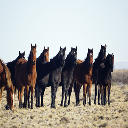

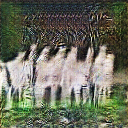

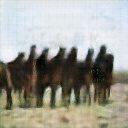

epoch: 35/5000, batch: 100/1067, GA2B_loss: 2.5675976276397705, GB2A_loss: 2.534273624420166
                             DA_loss: 0.0002587820345070213, DB_loss: 3.3342885785714316e-07, CYC_loss: 0.3136296570301056
epoch: 35/5000, batch: 200/1067, GA2B_loss: 2.7927396297454834, GB2A_loss: 2.808864116668701
                             DA_loss: 9.121808398049325e-05, DB_loss: 4.5355569454841316e-05, CYC_loss: 0.3622870445251465
epoch: 35/5000, batch: 300/1067, GA2B_loss: 2.9511361122131348, GB2A_loss: 2.9495582580566406
                             DA_loss: 0.00032704792101867497, DB_loss: 2.5835084670688957e-05, CYC_loss: 0.39154064655303955
epoch: 35/5000, batch: 400/1067, GA2B_loss: 2.396045684814453, GB2A_loss: 2.4792752265930176
                             DA_loss: 0.0002166703634429723, DB_loss: 0.0012703734682872891, CYC_loss: 0.2988622188568115
epoch: 35/5000, batch: 500/1067, GA2B_loss: 2.3250224590301514, GB2A_loss: 2.3567538261413574
                             DA_loss: 0.

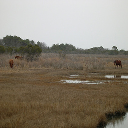

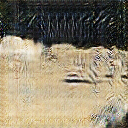

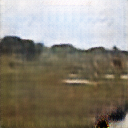

epoch: 36/5000, batch: 100/1067, GA2B_loss: 2.6660218238830566, GB2A_loss: 2.667123556137085
                             DA_loss: 0.0014581434661522508, DB_loss: 0.0006461350130848587, CYC_loss: 0.33353233337402344
epoch: 36/5000, batch: 200/1067, GA2B_loss: 3.388774871826172, GB2A_loss: 3.4217095375061035
                             DA_loss: 2.5249048121622764e-05, DB_loss: 0.00014135288074612617, CYC_loss: 0.48442357778549194
epoch: 36/5000, batch: 300/1067, GA2B_loss: 2.8337395191192627, GB2A_loss: 2.765045166015625
                             DA_loss: 0.0006302011897787452, DB_loss: 4.123581311432645e-05, CYC_loss: 0.3668012320995331
epoch: 36/5000, batch: 400/1067, GA2B_loss: 2.5982577800750732, GB2A_loss: 2.539654016494751
                             DA_loss: 0.0004470239218790084, DB_loss: 0.17019352316856384, CYC_loss: 0.3197093904018402
epoch: 36/5000, batch: 500/1067, GA2B_loss: 2.866410255432129, GB2A_loss: 2.613128423690796
                             DA_loss: 0.010430

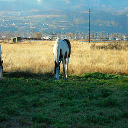

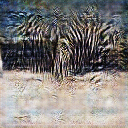

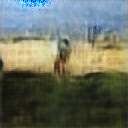

epoch: 37/5000, batch: 100/1067, GA2B_loss: 3.0984039306640625, GB2A_loss: 2.9983887672424316
                             DA_loss: 0.0019427620572969317, DB_loss: 8.200843876693398e-05, CYC_loss: 0.4238341748714447
epoch: 37/5000, batch: 200/1067, GA2B_loss: 2.654649496078491, GB2A_loss: 2.7568328380584717
                             DA_loss: 0.00036220403853803873, DB_loss: 0.003052891930565238, CYC_loss: 0.3609640896320343
epoch: 37/5000, batch: 300/1067, GA2B_loss: 3.437189817428589, GB2A_loss: 3.4182355403900146
                             DA_loss: 0.00015723939577583224, DB_loss: 0.00015729889855720103, CYC_loss: 0.49067753553390503
epoch: 37/5000, batch: 400/1067, GA2B_loss: 2.972395420074463, GB2A_loss: 3.051971435546875
                             DA_loss: 5.6407461812568727e-08, DB_loss: 0.0008388568530790508, CYC_loss: 0.4105275273323059
epoch: 37/5000, batch: 500/1067, GA2B_loss: 2.717059850692749, GB2A_loss: 2.758388042449951
                             DA_loss: 0.0001

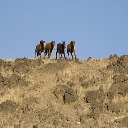

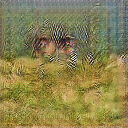

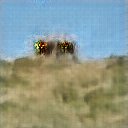

epoch: 38/5000, batch: 100/1067, GA2B_loss: 2.663278579711914, GB2A_loss: 2.5480308532714844
                             DA_loss: 0.004524880088865757, DB_loss: 0.00035847999970428646, CYC_loss: 0.34322234988212585
epoch: 38/5000, batch: 200/1067, GA2B_loss: 2.854769468307495, GB2A_loss: 2.8529911041259766
                             DA_loss: 3.3126407288364135e-06, DB_loss: 7.667285899515264e-07, CYC_loss: 0.37143784761428833
epoch: 38/5000, batch: 300/1067, GA2B_loss: 2.475703477859497, GB2A_loss: 2.43428897857666
                             DA_loss: 0.0006939216982573271, DB_loss: 7.74586878833361e-05, CYC_loss: 0.295279324054718
epoch: 38/5000, batch: 400/1067, GA2B_loss: 2.772088050842285, GB2A_loss: 2.835106372833252
                             DA_loss: 0.2855008840560913, DB_loss: 0.007916313596069813, CYC_loss: 0.369024395942688
epoch: 38/5000, batch: 500/1067, GA2B_loss: 3.216791868209839, GB2A_loss: 3.450756311416626
                             DA_loss: 9.787514500203542

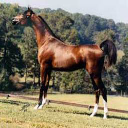

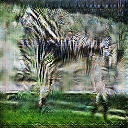

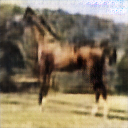

epoch: 39/5000, batch: 100/1067, GA2B_loss: 2.1057703495025635, GB2A_loss: 2.209218978881836
                             DA_loss: 7.624835234310012e-07, DB_loss: 0.0014799635391682386, CYC_loss: 0.24230259656906128
epoch: 39/5000, batch: 200/1067, GA2B_loss: 2.5135226249694824, GB2A_loss: 2.6831326484680176
                             DA_loss: 0.00015190047270152718, DB_loss: 0.0042445301078259945, CYC_loss: 0.33786115050315857
epoch: 39/5000, batch: 300/1067, GA2B_loss: 2.253490924835205, GB2A_loss: 2.3312253952026367
                             DA_loss: 0.14157640933990479, DB_loss: 0.002730206586420536, CYC_loss: 0.27323174476623535
epoch: 39/5000, batch: 400/1067, GA2B_loss: 2.7343196868896484, GB2A_loss: 2.1974568367004395
                             DA_loss: 0.06483790278434753, DB_loss: 0.0007005366496741772, CYC_loss: 0.3569002151489258
epoch: 39/5000, batch: 500/1067, GA2B_loss: 2.3366193771362305, GB2A_loss: 2.486189842224121
                             DA_loss: 0.000109

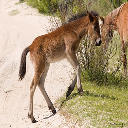

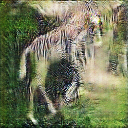

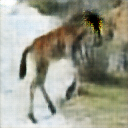

epoch: 40/5000, batch: 100/1067, GA2B_loss: 2.789273977279663, GB2A_loss: 3.0149166584014893
                             DA_loss: 6.972190749365836e-05, DB_loss: 0.007340217009186745, CYC_loss: 0.4033837616443634
epoch: 40/5000, batch: 200/1067, GA2B_loss: 2.5068588256835938, GB2A_loss: 2.5076370239257812
                             DA_loss: 7.804770802977146e-07, DB_loss: 1.4601880593545502e-06, CYC_loss: 0.30168041586875916
epoch: 40/5000, batch: 300/1067, GA2B_loss: 2.3705034255981445, GB2A_loss: 2.030221462249756
                             DA_loss: 0.018450461328029633, DB_loss: 9.497272912994958e-06, CYC_loss: 0.27550238370895386
epoch: 40/5000, batch: 400/1067, GA2B_loss: 2.7046236991882324, GB2A_loss: 2.7010843753814697
                             DA_loss: 0.0004874820006079972, DB_loss: 0.0010286754695698619, CYC_loss: 0.34268856048583984
epoch: 40/5000, batch: 500/1067, GA2B_loss: 2.1345720291137695, GB2A_loss: 2.16890811920166
                             DA_loss: 0.0007

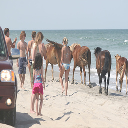

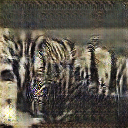

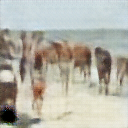

epoch: 41/5000, batch: 100/1067, GA2B_loss: 2.3085923194885254, GB2A_loss: 2.308910608291626
                             DA_loss: 0.00041268201312050223, DB_loss: 3.756880687433295e-06, CYC_loss: 0.26187318563461304
epoch: 41/5000, batch: 200/1067, GA2B_loss: 2.800265312194824, GB2A_loss: 2.6949172019958496
                             DA_loss: 0.0014698358718305826, DB_loss: 0.00029402467771433294, CYC_loss: 0.3600829839706421
epoch: 41/5000, batch: 300/1067, GA2B_loss: 2.6097445487976074, GB2A_loss: 2.6095502376556396
                             DA_loss: 3.271449531894177e-05, DB_loss: 0.033627476543188095, CYC_loss: 0.3220558166503906
epoch: 41/5000, batch: 400/1067, GA2B_loss: 2.280144691467285, GB2A_loss: 2.202755928039551
                             DA_loss: 0.0007820166647434235, DB_loss: 3.754772990305355e-07, CYC_loss: 0.25605642795562744
epoch: 41/5000, batch: 500/1067, GA2B_loss: 2.9312477111816406, GB2A_loss: 2.7623095512390137
                             DA_loss: 0.252

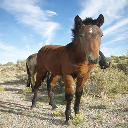

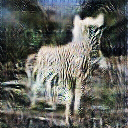

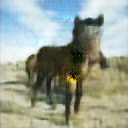

epoch: 42/5000, batch: 100/1067, GA2B_loss: 2.787238836288452, GB2A_loss: 2.785486936569214
                             DA_loss: 0.010098325088620186, DB_loss: 4.0497172449249774e-05, CYC_loss: 0.3576759099960327
epoch: 42/5000, batch: 200/1067, GA2B_loss: 2.473170757293701, GB2A_loss: 2.3351478576660156
                             DA_loss: 0.11306694895029068, DB_loss: 1.1782632100221235e-05, CYC_loss: 0.29647377133369446
epoch: 42/5000, batch: 300/1067, GA2B_loss: 2.4688291549682617, GB2A_loss: 2.6470155715942383
                             DA_loss: 0.00011528692994033918, DB_loss: 0.004818889778107405, CYC_loss: 0.33110707998275757
epoch: 42/5000, batch: 400/1067, GA2B_loss: 2.2270779609680176, GB2A_loss: 2.1077075004577637
                             DA_loss: 0.014883778989315033, DB_loss: 0.005345377139747143, CYC_loss: 0.28460097312927246
epoch: 42/5000, batch: 500/1067, GA2B_loss: 2.4312615394592285, GB2A_loss: 2.4311859607696533
                             DA_loss: 3.41986

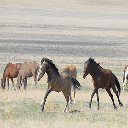

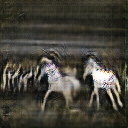

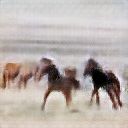

epoch: 43/5000, batch: 100/1067, GA2B_loss: 2.4295167922973633, GB2A_loss: 2.422372817993164
                             DA_loss: 0.03386865183711052, DB_loss: 5.091595994599629e-06, CYC_loss: 0.2870497405529022
epoch: 43/5000, batch: 200/1067, GA2B_loss: 2.913787841796875, GB2A_loss: 2.9066879749298096
                             DA_loss: 1.5225642528093886e-05, DB_loss: 0.0012382956920191646, CYC_loss: 0.38282111287117004
epoch: 43/5000, batch: 300/1067, GA2B_loss: 3.0316522121429443, GB2A_loss: 2.766178607940674
                             DA_loss: 0.010682168416678905, DB_loss: 3.850177108688513e-06, CYC_loss: 0.40742889046669006
epoch: 43/5000, batch: 400/1067, GA2B_loss: 3.2169840335845947, GB2A_loss: 3.2168285846710205
                             DA_loss: 0.0016585090197622776, DB_loss: 6.679979946966341e-08, CYC_loss: 0.4434507489204407
epoch: 43/5000, batch: 500/1067, GA2B_loss: 2.7099246978759766, GB2A_loss: 2.721835136413574
                             DA_loss: 3.652088

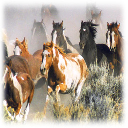

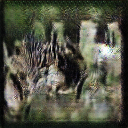

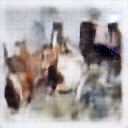

epoch: 44/5000, batch: 100/1067, GA2B_loss: 2.4129159450531006, GB2A_loss: 2.5543785095214844
                             DA_loss: 0.00423043966293335, DB_loss: 0.0027054352685809135, CYC_loss: 0.3109229505062103
epoch: 44/5000, batch: 200/1067, GA2B_loss: 2.4550018310546875, GB2A_loss: 2.5084378719329834
                             DA_loss: 5.3543866670224816e-05, DB_loss: 0.0017102929996326566, CYC_loss: 0.3049238920211792
epoch: 44/5000, batch: 300/1067, GA2B_loss: 2.9429242610931396, GB2A_loss: 2.9259188175201416
                             DA_loss: 4.486773832468316e-05, DB_loss: 2.7396461518947035e-05, CYC_loss: 0.38895493745803833
epoch: 44/5000, batch: 400/1067, GA2B_loss: 2.7746036052703857, GB2A_loss: 2.7809741497039795
                             DA_loss: 0.0014667254872620106, DB_loss: 3.805021697189659e-05, CYC_loss: 0.35645294189453125
epoch: 44/5000, batch: 500/1067, GA2B_loss: 2.5369884967803955, GB2A_loss: 2.5556983947753906
                             DA_loss: 0.

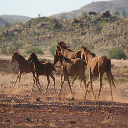

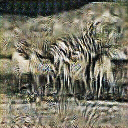

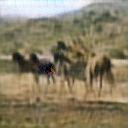

epoch: 45/5000, batch: 100/1067, GA2B_loss: 2.506028890609741, GB2A_loss: 2.5268306732177734
                             DA_loss: 0.002655281685292721, DB_loss: 5.531652641366236e-05, CYC_loss: 0.3053876757621765
epoch: 45/5000, batch: 200/1067, GA2B_loss: 3.05193829536438, GB2A_loss: 2.9296066761016846
                             DA_loss: 0.004461977630853653, DB_loss: 8.907636220101267e-05, CYC_loss: 0.4154972434043884
epoch: 45/5000, batch: 300/1067, GA2B_loss: 2.87231707572937, GB2A_loss: 2.882075071334839
                             DA_loss: 0.0007307364139705896, DB_loss: 0.003349134000018239, CYC_loss: 0.3914143443107605
epoch: 45/5000, batch: 400/1067, GA2B_loss: 2.7434473037719727, GB2A_loss: 2.9812591075897217
                             DA_loss: 0.005179470870643854, DB_loss: 0.017919346690177917, CYC_loss: 0.40079447627067566
epoch: 45/5000, batch: 500/1067, GA2B_loss: 2.7932066917419434, GB2A_loss: 2.7883896827697754
                             DA_loss: 4.495000030146

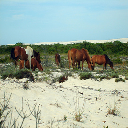

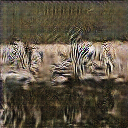

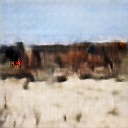

epoch: 46/5000, batch: 100/1067, GA2B_loss: 3.3708853721618652, GB2A_loss: 3.3688056468963623
                             DA_loss: 1.1542225365701597e-05, DB_loss: 1.3802559806208592e-05, CYC_loss: 0.4742044508457184
epoch: 46/5000, batch: 200/1067, GA2B_loss: 2.5453643798828125, GB2A_loss: 2.603330612182617
                             DA_loss: 1.2216956747579388e-05, DB_loss: 0.0006097839795984328, CYC_loss: 0.3226379156112671
epoch: 46/5000, batch: 300/1067, GA2B_loss: 2.2320728302001953, GB2A_loss: 2.4043197631835938
                             DA_loss: 0.0001064962925738655, DB_loss: 0.005641737952828407, CYC_loss: 0.2866416275501251
epoch: 46/5000, batch: 400/1067, GA2B_loss: 2.311825752258301, GB2A_loss: 2.4882495403289795
                             DA_loss: 0.0013565116096287966, DB_loss: 0.010644078254699707, CYC_loss: 0.31638702750205994
epoch: 46/5000, batch: 500/1067, GA2B_loss: 3.0202317237854004, GB2A_loss: 3.0120489597320557
                             DA_loss: 9.26

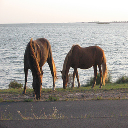

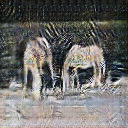

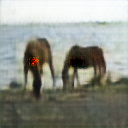

epoch: 47/5000, batch: 100/1067, GA2B_loss: 3.605614185333252, GB2A_loss: 3.5931379795074463
                             DA_loss: 2.142746416211594e-05, DB_loss: 1.5866588398694148e-07, CYC_loss: 0.5212361812591553
epoch: 47/5000, batch: 200/1067, GA2B_loss: 2.9096872806549072, GB2A_loss: 2.130107879638672
                             DA_loss: 0.14432676136493683, DB_loss: 5.166762275621295e-05, CYC_loss: 0.38319677114486694
epoch: 47/5000, batch: 300/1067, GA2B_loss: 2.4665191173553467, GB2A_loss: 2.1152539253234863
                             DA_loss: 0.022678907960653305, DB_loss: 0.00012210839486215264, CYC_loss: 0.2991687059402466
epoch: 47/5000, batch: 400/1067, GA2B_loss: 2.703909158706665, GB2A_loss: 2.6096577644348145
                             DA_loss: 0.04030976444482803, DB_loss: 0.18953299522399902, CYC_loss: 0.34150397777557373
epoch: 47/5000, batch: 500/1067, GA2B_loss: 2.0590338706970215, GB2A_loss: 2.055727481842041
                             DA_loss: 1.561522822

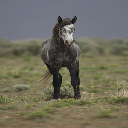

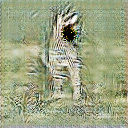

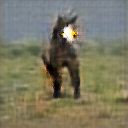

epoch: 48/5000, batch: 100/1067, GA2B_loss: 2.472621440887451, GB2A_loss: 2.4421215057373047
                             DA_loss: 0.0001193696225527674, DB_loss: 4.8422516556456685e-05, CYC_loss: 0.29454031586647034
epoch: 48/5000, batch: 200/1067, GA2B_loss: 2.3711097240448, GB2A_loss: 2.4619569778442383
                             DA_loss: 4.595632485671075e-10, DB_loss: 0.0010838120942935348, CYC_loss: 0.2923969328403473
epoch: 48/5000, batch: 300/1067, GA2B_loss: 2.124272108078003, GB2A_loss: 2.065181255340576
                             DA_loss: 0.0004896182217635214, DB_loss: 1.8097971405950375e-05, CYC_loss: 0.22535747289657593
epoch: 48/5000, batch: 400/1067, GA2B_loss: 2.4454452991485596, GB2A_loss: 2.4227986335754395
                             DA_loss: 0.0024228340480476618, DB_loss: 0.00165400595869869, CYC_loss: 0.31143343448638916
epoch: 48/5000, batch: 500/1067, GA2B_loss: 2.7404136657714844, GB2A_loss: 2.740886688232422
                             DA_loss: 1.164907

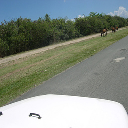

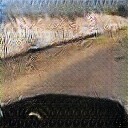

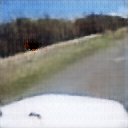

epoch: 49/5000, batch: 100/1067, GA2B_loss: 2.709378719329834, GB2A_loss: 1.9185572862625122
                             DA_loss: 0.16806206107139587, DB_loss: 0.00012816031812690198, CYC_loss: 0.34818342328071594
epoch: 49/5000, batch: 200/1067, GA2B_loss: 3.3286871910095215, GB2A_loss: 3.314215660095215
                             DA_loss: 2.8866292268503457e-05, DB_loss: 3.370964805071708e-07, CYC_loss: 0.4657782316207886
epoch: 49/5000, batch: 300/1067, GA2B_loss: 2.6936798095703125, GB2A_loss: 2.6909704208374023
                             DA_loss: 1.2226166745676892e-06, DB_loss: 0.0012654829770326614, CYC_loss: 0.33874309062957764
epoch: 49/5000, batch: 400/1067, GA2B_loss: 2.2017385959625244, GB2A_loss: 2.3473613262176514
                             DA_loss: 0.014819839037954807, DB_loss: 0.008626171387732029, CYC_loss: 0.2889811098575592
epoch: 49/5000, batch: 500/1067, GA2B_loss: 2.9034793376922607, GB2A_loss: 2.873868942260742
                             DA_loss: 0.0001

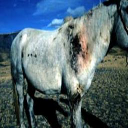

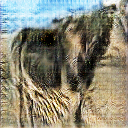

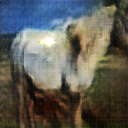

epoch: 50/5000, batch: 100/1067, GA2B_loss: 2.4172093868255615, GB2A_loss: 2.4027910232543945
                             DA_loss: 0.0008951252675615251, DB_loss: 0.00035078037763014436, CYC_loss: 0.28378766775131226
epoch: 50/5000, batch: 200/1067, GA2B_loss: 2.339301824569702, GB2A_loss: 2.3356118202209473
                             DA_loss: 7.884785190981347e-06, DB_loss: 3.90108745307316e-09, CYC_loss: 0.2678661346435547
epoch: 50/5000, batch: 300/1067, GA2B_loss: 1.805565357208252, GB2A_loss: 1.8214378356933594
                             DA_loss: 0.00021130245295353234, DB_loss: 3.343131538713351e-05, CYC_loss: 0.16436970233917236
epoch: 50/5000, batch: 400/1067, GA2B_loss: 2.2858669757843018, GB2A_loss: 2.2882399559020996
                             DA_loss: 3.9854559872765094e-05, DB_loss: 9.612024314265e-07, CYC_loss: 0.25768476724624634
epoch: 50/5000, batch: 500/1067, GA2B_loss: 2.7436935901641846, GB2A_loss: 2.7414886951446533
                             DA_loss: 1.48

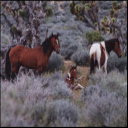

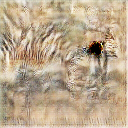

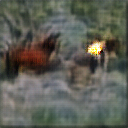

epoch: 51/5000, batch: 100/1067, GA2B_loss: 3.1260461807250977, GB2A_loss: 3.1012349128723145
                             DA_loss: 9.622325887903571e-05, DB_loss: 9.584092595105176e-07, CYC_loss: 0.4257574677467346
epoch: 51/5000, batch: 200/1067, GA2B_loss: 2.7026820182800293, GB2A_loss: 2.815528154373169
                             DA_loss: 7.065360114211217e-05, DB_loss: 0.0017315790755674243, CYC_loss: 0.3633832037448883
epoch: 51/5000, batch: 300/1067, GA2B_loss: 2.4310710430145264, GB2A_loss: 2.5458929538726807
                             DA_loss: 0.03305280581116676, DB_loss: 0.0034417249262332916, CYC_loss: 0.3122975826263428
epoch: 51/5000, batch: 400/1067, GA2B_loss: 3.139059066772461, GB2A_loss: 3.1381356716156006
                             DA_loss: 0.0002507393655832857, DB_loss: 0.004336920101195574, CYC_loss: 0.42782342433929443
epoch: 51/5000, batch: 500/1067, GA2B_loss: 2.1954824924468994, GB2A_loss: 2.201587677001953
                             DA_loss: 5.3697313

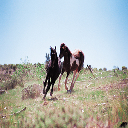

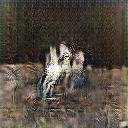

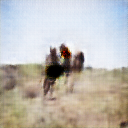

epoch: 52/5000, batch: 100/1067, GA2B_loss: 3.2280960083007812, GB2A_loss: 3.2273201942443848
                             DA_loss: 0.007925271056592464, DB_loss: 2.668206889211433e-06, CYC_loss: 0.4456239938735962
epoch: 52/5000, batch: 200/1067, GA2B_loss: 2.553969144821167, GB2A_loss: 2.573728322982788
                             DA_loss: 1.0994482181558851e-05, DB_loss: 6.663268140982836e-05, CYC_loss: 0.315381795167923
epoch: 52/5000, batch: 300/1067, GA2B_loss: 2.572437286376953, GB2A_loss: 2.57134747505188
                             DA_loss: 0.00026310101384297013, DB_loss: 3.6274407193559455e-06, CYC_loss: 0.3145907521247864
epoch: 52/5000, batch: 400/1067, GA2B_loss: 2.319230556488037, GB2A_loss: 2.424067258834839
                             DA_loss: 6.606447868762189e-07, DB_loss: 0.0014527114108204842, CYC_loss: 0.28482580184936523
epoch: 52/5000, batch: 500/1067, GA2B_loss: 2.5807669162750244, GB2A_loss: 2.5812530517578125
                             DA_loss: 1.3841479

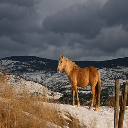

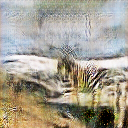

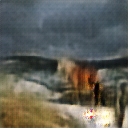

epoch: 53/5000, batch: 100/1067, GA2B_loss: 2.4589173793792725, GB2A_loss: 2.4585654735565186
                             DA_loss: 0.11189728230237961, DB_loss: 1.784514643077273e-05, CYC_loss: 0.2918030321598053
epoch: 53/5000, batch: 200/1067, GA2B_loss: 2.234238386154175, GB2A_loss: 2.2436673641204834
                             DA_loss: 1.9216727764614916e-07, DB_loss: 1.237616925209295e-05, CYC_loss: 0.24883273243904114
epoch: 53/5000, batch: 300/1067, GA2B_loss: 2.5538666248321533, GB2A_loss: 2.452547550201416
                             DA_loss: 0.0013658081879839301, DB_loss: 1.4612091092658375e-07, CYC_loss: 0.3108654022216797
epoch: 53/5000, batch: 400/1067, GA2B_loss: 2.730360507965088, GB2A_loss: 2.73030948638916
                             DA_loss: 0.01709219440817833, DB_loss: 0.0025144927203655243, CYC_loss: 0.3460739850997925
epoch: 53/5000, batch: 500/1067, GA2B_loss: 2.252936840057373, GB2A_loss: 2.2529027462005615
                             DA_loss: 1.661717533

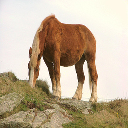

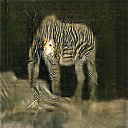

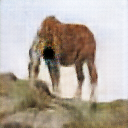

epoch: 54/5000, batch: 100/1067, GA2B_loss: 2.529663324356079, GB2A_loss: 2.5301527976989746
                             DA_loss: 0.40682172775268555, DB_loss: 1.0443963560646807e-07, CYC_loss: 0.3060486912727356
epoch: 54/5000, batch: 200/1067, GA2B_loss: 2.3104710578918457, GB2A_loss: 2.3022282123565674
                             DA_loss: 9.09766458789818e-06, DB_loss: 1.9532365058694268e-07, CYC_loss: 0.26214826107025146
epoch: 54/5000, batch: 300/1067, GA2B_loss: 2.843341588973999, GB2A_loss: 2.8389031887054443
                             DA_loss: 0.09180015325546265, DB_loss: 4.3567723650994594e-07, CYC_loss: 0.36897149682044983
epoch: 54/5000, batch: 400/1067, GA2B_loss: 2.3277039527893066, GB2A_loss: 2.33074951171875
                             DA_loss: 0.011728943325579166, DB_loss: 8.59084611875005e-05, CYC_loss: 0.2661572992801666
epoch: 54/5000, batch: 500/1067, GA2B_loss: 1.657567024230957, GB2A_loss: 2.26310658454895
                             DA_loss: 2.78410152532

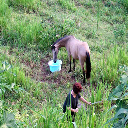

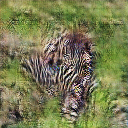

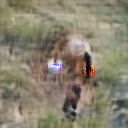

epoch: 55/5000, batch: 100/1067, GA2B_loss: 2.4187629222869873, GB2A_loss: 2.4127233028411865
                             DA_loss: 0.0026468506548553705, DB_loss: 0.1312141865491867, CYC_loss: 0.2899056673049927
epoch: 55/5000, batch: 200/1067, GA2B_loss: 2.610740900039673, GB2A_loss: 2.7681803703308105
                             DA_loss: 0.023644642904400826, DB_loss: 0.009144709445536137, CYC_loss: 0.370536744594574
epoch: 55/5000, batch: 300/1067, GA2B_loss: 2.2761521339416504, GB2A_loss: 1.9832651615142822
                             DA_loss: 0.01266286801546812, DB_loss: 4.075086508237291e-06, CYC_loss: 0.25524410605430603
epoch: 55/5000, batch: 400/1067, GA2B_loss: 2.3211452960968018, GB2A_loss: 2.31644868850708
                             DA_loss: 0.010738661512732506, DB_loss: 2.1675355128536467e-06, CYC_loss: 0.2643284201622009
epoch: 55/5000, batch: 500/1067, GA2B_loss: 2.5160913467407227, GB2A_loss: 2.5044984817504883
                             DA_loss: 0.000100068114

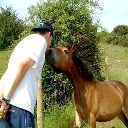

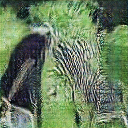

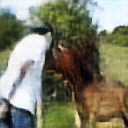

epoch: 56/5000, batch: 100/1067, GA2B_loss: 2.3310890197753906, GB2A_loss: 1.334715485572815
                             DA_loss: 0.44165220856666565, DB_loss: 9.55193346641181e-09, CYC_loss: 0.2662193179130554
epoch: 56/5000, batch: 200/1067, GA2B_loss: 2.500964879989624, GB2A_loss: 2.501110553741455
                             DA_loss: 0.00037587751285173, DB_loss: 5.711504513783439e-07, CYC_loss: 0.3002563714981079
epoch: 56/5000, batch: 300/1067, GA2B_loss: 2.7272160053253174, GB2A_loss: 2.729180097579956
                             DA_loss: 2.769068032648647e-06, DB_loss: 5.074820705885941e-07, CYC_loss: 0.34584346413612366
epoch: 56/5000, batch: 400/1067, GA2B_loss: 2.120151996612549, GB2A_loss: 2.0399856567382812
                             DA_loss: 0.0008924864232540131, DB_loss: 1.0755220500868745e-06, CYC_loss: 0.22452983260154724
epoch: 56/5000, batch: 500/1067, GA2B_loss: 2.503314256668091, GB2A_loss: 2.46297550201416
                             DA_loss: 0.000207812190

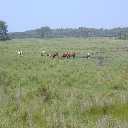

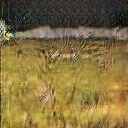

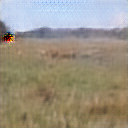

epoch: 57/5000, batch: 100/1067, GA2B_loss: 2.0361688137054443, GB2A_loss: 2.064584732055664
                             DA_loss: 5.111342460395463e-09, DB_loss: 0.00039674926665611565, CYC_loss: 0.21292591094970703
epoch: 57/5000, batch: 200/1067, GA2B_loss: 2.9900028705596924, GB2A_loss: 2.997572660446167
                             DA_loss: 0.2449643760919571, DB_loss: 2.6376868845545687e-05, CYC_loss: 0.4008953273296356
epoch: 57/5000, batch: 300/1067, GA2B_loss: 2.1135056018829346, GB2A_loss: 2.2226366996765137
                             DA_loss: 0.006855545099824667, DB_loss: 0.002064283937215805, CYC_loss: 0.24757573008537292
epoch: 57/5000, batch: 400/1067, GA2B_loss: 2.6320085525512695, GB2A_loss: 2.6323442459106445
                             DA_loss: 1.3208267368725046e-08, DB_loss: 2.5147912197098776e-08, CYC_loss: 0.3264913558959961
epoch: 57/5000, batch: 500/1067, GA2B_loss: 2.4495108127593994, GB2A_loss: 2.439210891723633
                             DA_loss: 1.6939

In [0]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB, lambda_cyc)
        
        # Show current loss
        if (n_batch) % 100 == 0:
            print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch}/{len(data_loader_train)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
            print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")    
          
        # Show fake samples
        if n_batch == 10:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())
